<a href="https://colab.research.google.com/github/natasha-kolom/Machine_learning/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [94]:
import pandas as pd
import numpy as np

In [95]:
train_fname = 'tweet_sentiment_train.csv.zip'
raw_df = pd.read_csv(train_fname)

In [96]:
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [97]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [98]:
raw_df = raw_df.dropna()

In [99]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



<Axes: ylabel='sentiment'>

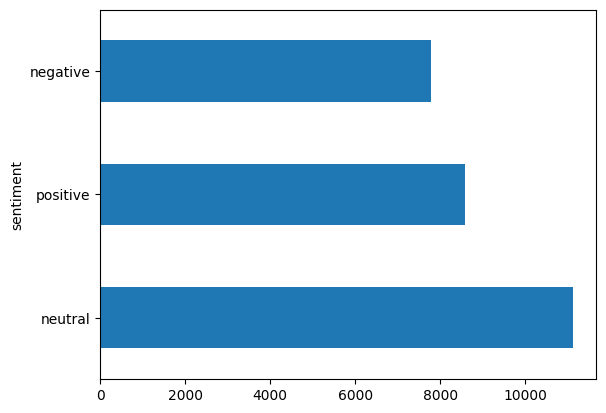

In [100]:
raw_df.sentiment.value_counts().plot(kind='barh')

In [101]:
raw_df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


In [102]:
raw_df[raw_df['sentiment']=='neutral'][:5]['text']

,text
0,"I`d have responded, if I were going"
5,http://www.dothebouncy.com/smf - some shameles...
7,Soooo high
8,Both of you
10,"as much as i love to be hopeful, i reckon the..."


In [103]:
raw_df[raw_df['sentiment']=='positive'][:5]['text']

,text
6,2am feedings for the baby are fun when he is a...
9,Journey!? Wow... u just became cooler. hehe....
11,I really really like the song Love Story by Ta...
21,Playing Ghost Online is really interesting. Th...
25,"the free fillin` app on my ipod is fun, im add..."


In [104]:
raw_df[raw_df['sentiment']=='negative'][:5]['text']

,text
1,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...
3,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t..."
12,My Sharpie is running DANGERously low on ink


**Спостереження**
В нас є три класи - найтральний, позитивний і негативний. Найбільше даних в нейтральному класі, трішки менше в позитивному і найменше в негативному. Розподіл не ідеально збалансований, але й немає великих перекосів.

In [105]:
raw_df['text_len'] = raw_df.text.apply(len)

<Axes: >

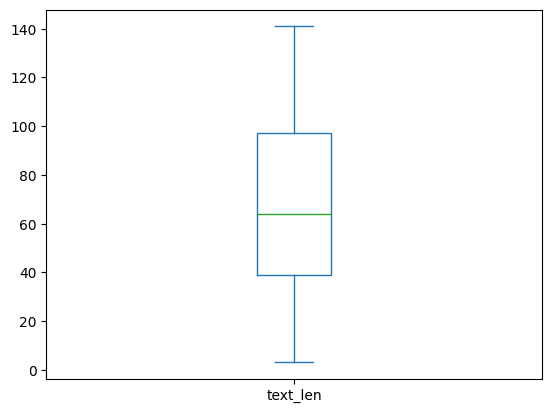

In [106]:
raw_df.text_len.plot.box()

In [107]:
raw_df.text_len.describe()

,text_len
count,27480.000000
mean,68.330022
std,35.603870
min,3.000000
25%,39.000000
50%,64.000000
75%,97.000000
max,141.000000


**Спостереження**
Довжини текстів розподіляються від 3 символів до 141 символа. Середня довжина тексту - 64 символи.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [108]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize

In [109]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(raw_df.text)

In [110]:
print(f"Кількість унікальних слів: {len(vectorizer.get_feature_names_out())}")

Кількість унікальних слів: 26439


In [111]:
vectorizer_s = CountVectorizer()
X_s = vectorizer_s.fit_transform(raw_df.selected_text)

In [112]:
print(f"Кількість унікальних слів: {len(vectorizer_s.get_feature_names_out())}")

Кількість унікальних слів: 17620


In [113]:
vectorizer.get_feature_names_out()[10000:10010]

array(['forgotten', 'forgottten', 'fork', 'forked', 'form', 'formal',
       'formally', 'format', 'former', 'formidable'], dtype=object)

In [114]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [115]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words='english',
                             max_features=1000)

In [116]:
%%time
vectorizer.fit(raw_df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

CPU times: user 11.3 s, sys: 28.6 ms, total: 11.3 s
Wall time: 11.4 s


CountVectorizer(max_features=1000, stop_words='english',
                tokenizer=<function tokenize at 0x7fc7c8de1cf0>)

In [117]:
%%time
inputs = vectorizer.transform(raw_df.text)

CPU times: user 10.9 s, sys: 34.4 ms, total: 10.9 s
Wall time: 11 s


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [118]:
from sklearn.model_selection import train_test_split

In [119]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(inputs, raw_df.sentiment,
                                                                        test_size=0.2, random_state=42)

In [120]:
from sklearn.linear_model import LogisticRegression

In [121]:
model = LogisticRegression(max_iter=1000, solver='sag')

In [122]:
%%time
model.fit(X_train_bow, y_train)

CPU times: user 9.74 s, sys: 9.74 ms, total: 9.75 s
Wall time: 9.81 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, solver='sag')

In [123]:
train_preds = model.predict(X_train_bow)

In [124]:
from sklearn.metrics import accuracy_score, f1_score

In [125]:
f1_score(y_train, train_preds,average='micro')

0.7369450509461426

In [126]:
test_preds = model.predict(X_test_bow)
f1_score(y_test, test_preds,average='micro')

0.6974163027656477

In [127]:
from sklearn.tree import DecisionTreeClassifier

In [128]:
model_rt = DecisionTreeClassifier(random_state=42)

In [129]:
model_rt.fit(X_train_bow, y_train)

DecisionTreeClassifier(random_state=42)

In [130]:
train_preds_rt = model_rt.predict(X_train_bow)

In [131]:
f1_score(y_train, train_preds_rt,average='micro')

0.9878548034934498

In [132]:
test_preds = model_rt.predict(X_test_bow)
f1_score(y_test, test_preds,average='micro')

0.6257278020378457

In [133]:
from xgboost import XGBClassifier

In [134]:
category_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train = y_train.map(category_mapping)

In [135]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(X_train_bow, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:29] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:29] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [142]:
train_preds_xgb = xgb_clf.predict(X_train_bow)

In [145]:
f1_score(y_train, train_preds_xgb,average='micro')

0.606759461426492

**Спостереження**
Логістична регресія дала гарний результат f1_score 0.73, дерева рішень показують перенавчання, так як на тестових даних скор значно нижчий ніж на тренувальних, XGBoost дав нижчий результат за логістичну регресію

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [64]:
feature_importance = pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

,imp
sad,2.419490
suck,2.259756
hate,2.138921
bore,2.098737
sorri,2.094294
...,...
cute,-1.821993
thank,-2.006328
love,-2.052157
glad,-2.066280


**Спостереження** Я вважаю, що слова sad, suck, hate, bore і т.д. цілком логічно впливають на сентимент

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [150]:
tf_vectorizer = TfidfVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words='english',
                             max_features=1000)

In [151]:
tf_vectorizer.fit(raw_df.text)
tf_inputs = tf_vectorizer.transform(raw_df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

In [152]:
X_train_tf, X_test_tf, y_train, y_test = train_test_split(tf_inputs, raw_df.sentiment,
                                                                        test_size=0.2, random_state=42)

In [153]:
model = LogisticRegression(max_iter=1000, solver='sag')
model.fit(X_train_tf, y_train)
train_preds = model.predict(X_train_tf)
f1_score(y_train, train_preds,average='micro')

0.7303948326055313

In [154]:
test_preds = model.predict(X_test_tf)
f1_score(y_test, test_preds,average='micro')

0.6921397379912664

In [155]:
feature_importance = pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

,imp
sad,5.002885
miss,4.821679
suck,4.283886
hate,4.244063
sorri,4.050882
...,...
glad,-2.867752
hope,-3.129414
awesom,-3.633871
thank,-4.050226


**Спостереження** Якість моделі залишилась такою ж як і з векторизацією мішком слів. Токени, що впливають на сентимент такі самі sad, miss, suck,hate, sorri

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [156]:
from sklearn.metrics import confusion_matrix

In [157]:
raw_df['prediction'] = model.predict(tf_inputs)

In [161]:
confusion_matrix(raw_df.sentiment, raw_df.prediction)

array([[4942, 2430,  409],
       [1312, 8633, 1172],
       [ 362, 1934, 6286]])

In [162]:
raw_df['error'] = raw_df.sentiment != raw_df['prediction']

In [176]:
raw_df[raw_df.error & (raw_df.sentiment=='positive')]

,textID,text,selected_text,sentiment,text_len,prediction,error
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive,135,neutral,True
30,d33f811375,I`m going home now. Have you seen my new twitt...,Quite....heavenly,positive,84,neutral,True
68,fa2654e730,Chilliin,Chilliin,positive,8,neutral,True
71,a4e00d4d26,a celtics-lakers rematch sounds better don`t ...,better,positive,60,neutral,True
81,58d382e07a,lucky kid...i so wanna see loserville pity i...,lucky,positive,57,neutral,True
...,...,...,...,...,...,...,...
27417,2151413f96,ish okay my loveee,ish okay my loveee,positive,18,neutral,True
27455,768e382964,simple greetings from unexpected people can ac...,simple greetings from unexpected people can ac...,positive,101,negative,True
27458,ea8072c6a6,I really wish someone would make a groupchat t...,really wish,positive,108,neutral,True
27474,8f14bb2715,So I get up early and I feel good about the da...,I feel good ab,positive,126,negative,True


In [177]:
raw_df[raw_df.error & (raw_df.sentiment=='negative')]

,textID,text,selected_text,sentiment,text_len,prediction,error
2,088c60f138,my boss is bullying me...,bullying me,negative,25,neutral,True
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,neutral,True
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,44,neutral,True
15,8a939bfb59,"Uh oh, I am sunburned","Uh oh, I am sunburned",negative,21,neutral,True
16,3440297f8b,"S`ok, trying to plot alternatives as we speak...",*sigh*,negative,53,neutral,True
...,...,...,...,...,...,...,...
27439,ecfc3c4122,I am beginning to think sun blcok is a haox.,haox.,negative,44,neutral,True
27440,7fd422900b,I GET IT. YOU ESPLAINED IT TO ME AWHILE AGO.,I GET IT.,negative,46,neutral,True
27470,778184dff1,lol i know and haha..did you fall asleep?? o...,t bored,negative,79,neutral,True
27472,8f5adc47ec,http://twitpic.com/663vr - Wanted to visit the...,were too late,negative,75,neutral,True


**Спостереження** модель розпізнає багато коментарів, які є явно позитивними або явно негативними, як нейтральні. Шляхи покращення:
1. Збільшити параметр max_features при векторизації
2. Натренувати моделі з більшою кількістю ітерацій
3. Збалансувати класи

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model